# Setup

In [1]:
import os
import random
from copy import deepcopy
import shutil
from fastai.vision import *
from pathlib import Path
from fastai.widgets import *
from tulin.fastai.callback import Callback

In [2]:
np.random.seed(42)
bs = 56
path = Path("./data/images/processed")

# Load Data

In [3]:
def LoadData(path, bs=64, size=224, valid="valid"):
    return (ImageList.from_folder(path)    
            .split_by_rand_pct(0.2, 42)
            .label_from_folder()
            .transform(get_transforms(), size=size) 
            .databunch(bs=bs)).normalize(imagenet_stats)

# resnet50 - 256

In [4]:
data = LoadData(path, bs, 256)
learner = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate], wd=0.1)
learner.callbacks.append(Callback(learner, "error_rate", "base", "wd-0.1-e-10-5"))

In [5]:
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.248550,0.693123,0.787366,0.212634,02:06
1,0.911747,0.606444,0.819486,0.180514,02:05
2,0.758152,0.545618,0.834047,0.165953,02:05
3,0.640518,0.483977,0.850107,0.149893,02:05
4,0.562196,0.480681,0.852248,0.147752,02:05
5,0.487851,0.432263,0.865953,0.134047,02:05
6,0.380924,0.395947,0.874518,0.125482,02:05
7,0.308712,0.382720,0.879443,0.120557,02:06
8,0.269117,0.369660,0.885439,0.114561,02:05
9,0.243089,0.368416,0.884797,0.115203,02:05


# resnet50 - 256 - learning rate + unfreeze

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-07


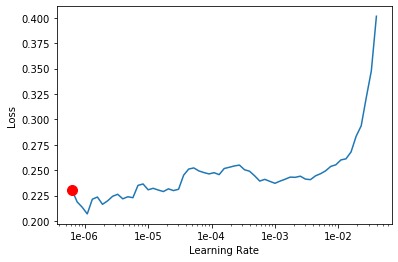

In [6]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [7]:
learner.unfreeze()
learner.fit_one_cycle(5, slice(learner.recorder.min_grad_lr), 1e-6)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.258436,0.368145,0.888009,0.111991,02:41
1,0.254014,0.368213,0.886724,0.113276,02:41
2,0.259205,0.367229,0.885653,0.114347,02:41
3,0.247500,0.369589,0.886724,0.113276,02:42
4,0.221251,0.366863,0.886938,0.113062,02:41


# Export

In [12]:
learner.callbacks = []
learner.export("export.pkl")